<a href="https://colab.research.google.com/github/Molten-Ice/de-identification/blob/colab/dev-notebooks/12-parallelization-and-gender-race-alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

repo_dir = '/content/'
!wget -P {repo_dir} https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

style_gan_dir = repo_dir + 'stylegan2-ada-pytorch'
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git {style_gan_dir}

!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/cropped_face.jpg content/

!pip install facenet-pytorch

!pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.8
    Uninstalling imageio-ffmpeg-0.4.8:
      Successfully uninstalled imageio-ffmpeg-0.4.8
--2023-04-27 18:51:19--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 13.35.24.10, 13.35.24.122, 13.35.24.22, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|13.35.24.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘/content/ffhq.pkl’

ffhq.pkl            100%[=================

In [2]:
!nvidia-smi

Thu Apr 27 18:51:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/16070.jpg

--2023-04-27 18:51:39--  https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/16070.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48119 (47K) [image/jpeg]
Saving to: ‘16070.jpg’

16070.jpg           100%[===================>]  46.99K  --.-KB/s    in 0.01s   

2023-04-27 18:51:39 (3.65 MB/s) - ‘16070.jpg’ saved [48119/48119]



In [4]:
import cv2
import time
import torch
import pickle
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageOps
from deepface import DeepFace
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, repo_dir + 'stylegan2-ada-pytorch')
import dnnlib
import torch_utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert device.type == "cuda", "Error, not running on gpu!"

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [5]:
with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
with open('ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device)  # torch.nn.Module
# First time running through sets up pluggins and takes a few minutes, after that takes < 1 second
z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels

print(f"G parameters: {sum(p.numel() for p in G.parameters()):,} | D Parameters: {sum(p.numel() for p in D.parameters()):,}")
#I think all losses are negative. The closer to 0 it is the worse it performs.
# e.g. -0.03 is random noise, -1.8 is a generated img

filename = '16070.jpg'
original_img = Image.open(filename)
objs = DeepFace.analyze(img_path = filename, actions = ['age', 'gender', 'race'], enforce_detection = False)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
G parameters: 30,370,060 | D Parameters: 29,012,513
age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [00:14<00:00, 36.0MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:13<00:00, 40.5MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [00:13<00:00, 39.9MB/s]
Action: race: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


In [6]:
def generate_boxes_landmarks(img, mtcnn, device):
    all_boxes, all_probs, all_landmarks = mtcnn.detect(torch.Tensor(img).to(device), landmarks=True)
    if all_boxes is None: return [], [], []
    all_boxes = [[int(x) for x in box] for box in all_boxes] 
    all_landmarks = [[[int(x), int(y)] for x, y in point] for point in all_landmarks] 

    boxes, probs, landmarks, centres = [], [], [], []
    threshold = 0.9
    for box, prob, landmark in zip(all_boxes, all_probs, all_landmarks):
            if prob >= threshold:
                boxes.append(box)
                probs.append(prob)
                landmarks.append(landmark)
    # print(f"[{len(boxes)}/{len(all_boxes)}] faces used")
    return boxes, landmarks, probs


def display_img_func(img, size = (500, 500)):

    """Torch tensor -> displaying PIL Image"""
    torch_grid = torchvision.utils.make_grid(img, normalize = True, padding = 0)
    display_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
    display(ImageOps.contain(Image.fromarray(display_img), size))


real_face = cv2.imread('cropped_face.jpg')
real_face = cv2.cvtColor(real_face, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(real_face))
border_factor = 0.15
### Real_face inputted as parameter to mode, as well as border_factor
# Deepface seems awful on the face I tested out, maybe it's better on others
real_traits = {'age': 29,
               'dominant_gender': 'Woman',
               'dominant_race' : 'white'}

mtcnn = MTCNN(keep_all=True, device=device) #loading face detection model

In [7]:
def find_best_zs(mtcnn, G, real_traits, iterations = 15, samples_wanted = 5, silent = True):
    best_zs = [] # [(age diff, z),...]
    for i in range(iterations):
        if len(best_zs) == samples_wanted:
            break
        z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
        img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
        torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True)
        np_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
        boxes, landmarks, probs = generate_boxes_landmarks(np_img, mtcnn, device)
        if len(boxes) == 0:
            print("No faces found!! skip example")
            continue

        box_generated = boxes[0]
        display_img = np_img[box_generated[1]:box_generated[3], box_generated[0]:box_generated[2]]
        cv2.imwrite("temp.jpg", display_img)
        generated_traits = DeepFace.analyze(img_path = "temp.jpg", actions = ['age', 'gender', 'race'], enforce_detection = False, silent = silent)
        matching = True
        for key in ['dominant_gender', 'dominant_race']:
            if real_traits[key] != generated_traits[0][key]:
                print(f"Not matching on: {key}")
                matching = False
                break

        if not matching: continue
        age_diff = abs(real_traits['age'] - generated_traits[0]['age'])
        best_zs.append([age_diff, z, box_generated])
    # best_zs = sorted(best_zs, key=lambda x: x[0], reverse=False)
    return best_zs

best_zs = find_best_zs(mtcnn, G, real_traits)
len(best_zs), best_zs[0][0], best_zs[-1][0]

Not matching on: dominant_gender
Not matching on: dominant_gender
Not matching on: dominant_gender
Not matching on: dominant_gender
Not matching on: dominant_gender
Not matching on: dominant_gender
Not matching on: dominant_race
Not matching on: dominant_gender
Not matching on: dominant_race
Not matching on: dominant_race
Not matching on: dominant_gender
Not matching on: dominant_gender
Not matching on: dominant_gender


(2, 1, 6)

In [37]:
border_factor = 0.15
tensor_transform = transforms.ToTensor()

training_images = []
for _, z, box in best_zs:
    #Generate image
    img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels

    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1

    #Create a mask of the cropped image's border
    border_width = int(width*border_factor)
    border_height = int(height*border_factor)
    mask = torch.zeros((1, 3, 1024, 1024)).to(device)
    mask[:, :, y1:y2, x1:x2] = 1
    mask[:, :, y1+border_height:y2-border_height, x1+border_width:x2-border_width] = 0

    resized_face = cv2.resize(real_face, [width, height])
    real_face_tensor = torch.zeros((1, 3, 1024, 1024)).to(device)
    real_face_tensor[:, :, y1:y2, x1:x2] = tensor_transform(resized_face).unsqueeze(dim=0).to(device)
    training_images.append([z, box, real_face_tensor, mask])

In [38]:
def tensor_to_np(img):
    """Torch tensor -> normalized np image"""
    torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True, padding = 0)
    return np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)

def display_and_concat(images,size = (800,800)):
    images_to_concat = []
    for image in images:
        images_to_concat.append(tensor_to_np(image))
    
    display_img = np.concatenate(images_to_concat,axis=1)
    display(ImageOps.contain(Image.fromarray(display_img), size))

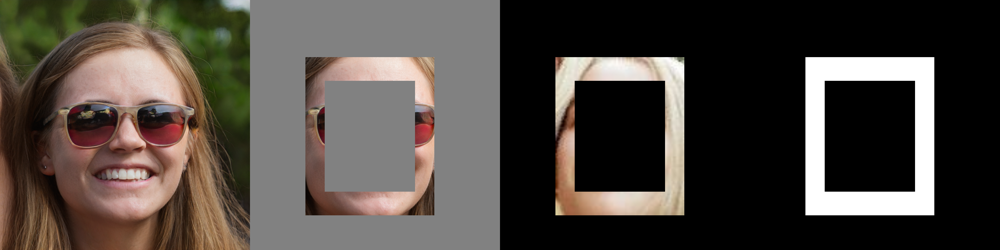

tensor(0.1202, device='cuda:0')


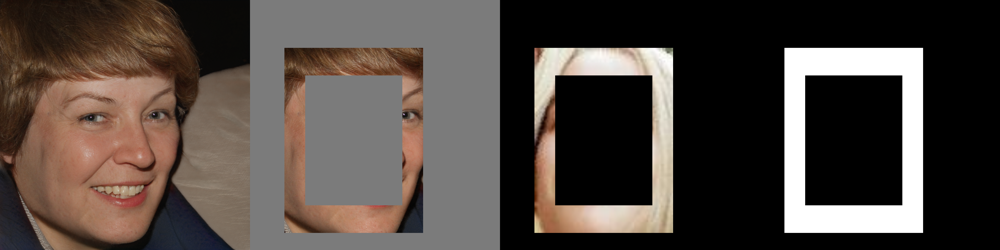

tensor(0.2000, device='cuda:0')


In [40]:
training_images = training_images[:2] # DELETE (later on)
for z, box, real_face_tensor, mask in training_images:
    img = G(z, None) 
    display_and_concat([img, img*mask, real_face_tensor*mask, mask], size = (1000, 1000))
    # display_img_func((real_face_tensor*mask).cpu())
    # display_img_func((img*mask).cpu())
    contextual_loss = nn.functional.l1_loss(real_face_tensor*mask, img*mask)
    print(contextual_loss)

In [25]:
torch.cuda.empty_cache()

In [26]:
!nvidia-smi

Thu Apr 27 19:03:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |  11027MiB / 15360MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
zs = [array[0] for array in training_images]
fixed_noise = torch.cat(zs, dim=0).clone().requires_grad_(True) #512 input latent vector

# real_face = real_face_tensor.clone().to(device)
# mask = mask.to(device)

lr = 0.0003
iterations = 1500
lam = 0.1 # perceptual_loss factor
eval_interval = 50

progress = []

# criterion = nn.BCELoss()
optimizer = optim.Adam([fixed_noise], lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

In [28]:
t_start = time.time()
for i in range(iterations):
    fake_faces = G(fixed_noise, None)
    perceptual_loss = torch.sum(D(fake_faces, None).view(-1))# unbounded, the more negative, the more confident D is that it's real
    
    contextual_losses = []
    for face_idx, (_, _, real_face_tensor, mask) in enumerate(training_images):
        fake_face = fake_faces[face_idx].unsqueeze(dim=0)
        contextual_loss_singular = nn.functional.l1_loss(real_face_tensor*mask, fake_face*mask)
        contextual_losses.append(contextual_loss_singular)
        # display_and_concat([fake_face*mask, real_face_tensor*mask, mask])
    contextual_loss = sum(contextual_losses)
    
    complete_loss = contextual_loss + lam*perceptual_loss

    optimizer.zero_grad()
    complete_loss.backward()
    optimizer.step()
    scheduler.step()

    if i % eval_interval == 0:
        print(f"Losses, {i} iteration:: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f}, perceptual:{lam*perceptual_loss:.4f} (after x0.1), time: {time.time()-t_start:.2f}s")

Losses, 0 iteration:: Complete:-0.1695, contextual:0.3206, perceptual:-0.4901 (after x0.1), time: 0.42s
Losses, 50 iteration:: Complete:-0.3293, contextual:0.3119, perceptual:-0.6413 (after x0.1), time: 18.38s
Losses, 100 iteration:: Complete:-0.4771, contextual:0.3032, perceptual:-0.7803 (after x0.1), time: 36.72s
Losses, 150 iteration:: Complete:-0.5550, contextual:0.2895, perceptual:-0.8445 (after x0.1), time: 54.25s
Losses, 200 iteration:: Complete:-0.6049, contextual:0.2773, perceptual:-0.8822 (after x0.1), time: 71.45s
Losses, 250 iteration:: Complete:-0.6448, contextual:0.2679, perceptual:-0.9128 (after x0.1), time: 88.70s
Losses, 300 iteration:: Complete:-0.6933, contextual:0.2604, perceptual:-0.9538 (after x0.1), time: 106.26s
Losses, 350 iteration:: Complete:-0.6825, contextual:0.2560, perceptual:-0.9385 (after x0.1), time: 124.00s
Losses, 400 iteration:: Complete:-0.7348, contextual:0.2498, perceptual:-0.9846 (after x0.1), time: 141.67s
Losses, 450 iteration:: Complete:-0.73

KeyboardInterrupt: ignored

In [29]:
# Loss mean:
# Losses, 0 iteration:: Complete:-0.0708, contextual:0.1607, perceptual:-0.2315 (after x0.1), time: 0.38s
# Losses, 1000 iteration:: Complete:-0.4051, contextual:0.1029, perceptual:-0.5080 (after x0.1), time: 351.21s

#Losses sum:
# Losses, 0 iteration:: Complete:-0.1695, contextual:0.3206, perceptual:-0.4901 (after x0.1), time: 0.42s
# Losses, 1000 iteration:: Complete:-0.8734, contextual:0.2073, perceptual:-1.0807 (after x0.1), time: 351.96s

In [45]:
torch.cuda.empty_cache()

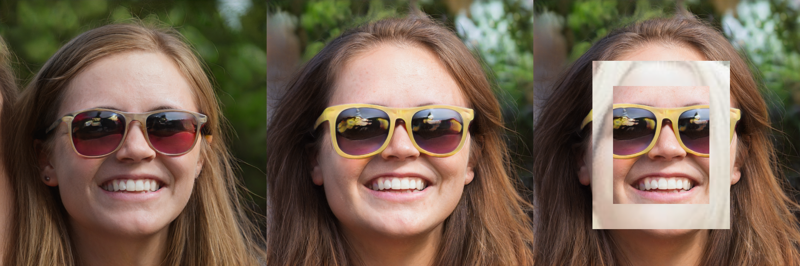

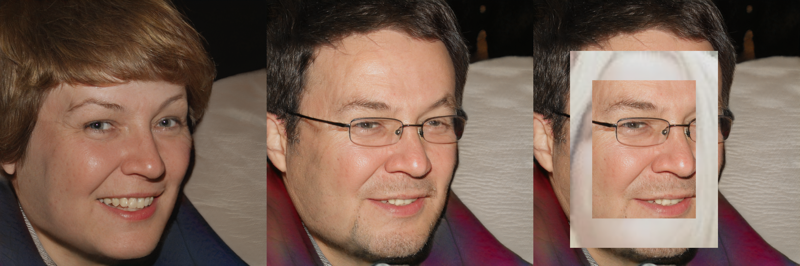

In [44]:
fake_faces = G(fixed_noise, None)
for face_idx, (z, box, real_face_tensor, mask) in enumerate(training_images):
    original_fake_face = G(z, None) 
    fake_face = fake_faces[face_idx].unsqueeze(dim=0)
    display_and_concat([original_fake_face, fake_face, real_face_tensor*mask+ fake_face*(1-mask)], size = (800, 800))
    # display_and_concat([real_face_tensor*mask+ fake_face*(1-mask), fake_face*mask, real_face_tensor*mask, mask], size = (1200, 1200))